<a href="https://colab.research.google.com/github/Pravin-surawase/structural_engineering_lib/blob/main/colab_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structural Lib IS 456 - Colab Demo (v0.15.0)

This notebook demonstrates the complete workflow:
1. **Design** - Beam flexure and shear design per IS 456
2. **Outputs** - BBS, DXF drawings, HTML reports
3. **Insights + Smart Design** - Precheck, sensitivity, constructability, smart dashboard, comparison (v0.15)


In [1]:
!pip -q install -U "structural-lib-is456[dxf]>=0.15.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.5/150.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.0 MB/s eta 0:00:00


In [2]:
from structural_lib import api
print('Version:', api.get_library_version())


Version: 0.15.0


In [3]:
from structural_lib import flexure

res = flexure.design_singly_reinforced(
    b=300, d=450, d_total=500, mu_knm=150, fck=25, fy=500
)
print('Ast required (mm^2):', round(res.ast_required))
print('Status:', 'OK' if res.is_safe else res.error_message)


Ast required (mm^2): 882
Status: OK


In [4]:
import json

job = {
    'schema_version': 1,
    'code': 'IS456',
    'units': 'IS456',
    'job_id': 'colab_job_001',
    'beam': {
        'b_mm': 230,
        'D_mm': 500,
        'd_mm': 450,
        'd_dash_mm': 50,
        'fck_nmm2': 25,
        'fy_nmm2': 500,
        'asv_mm2': 100,
    },
    'cases': [
        {'case_id': 'LC1', 'mu_knm': 80, 'vu_kn': 55},
        {'case_id': 'LC2', 'mu_knm': 110, 'vu_kn': 75},
        {'case_id': 'LC3', 'mu_knm': 140, 'vu_kn': 95},
    ],
}

with open('job.json', 'w', encoding='utf-8') as f:
    json.dump(job, f, indent=2)

print('Wrote job.json')


Wrote job.json


In [5]:
!python -m structural_lib job job.json -o ./job_out
!python -m structural_lib critical ./job_out --top 5 --format=csv -o critical.csv
!python -m structural_lib report ./job_out --format=html -o report.html


Running job from job.json...
Job complete: outputs written to ./job_out
Loading report data from job_out...
Found 3 case(s) (top=5)
Critical set written to critical.csv
Loading report data from job_out...
Report written to report.html


In [6]:
from IPython.display import HTML, IFrame, display
from pathlib import Path
import pandas as pd

display(HTML(Path('report.html').read_text(encoding='utf-8')))
pd.read_csv('critical.csv').head(5)


,case_id,utilization,flexure_util,shear_util,is_ok,json_path
0,LC3,0.8999,0.8999,0.2961,True,cases[2]
1,LC2,0.7071,0.7071,0.2338,True,cases[1]
2,LC1,0.5142,0.5142,0.1714,True,cases[0]


In [7]:
# If inline HTML does not render, use an iframe:
IFrame('report.html', width=900, height=600)


## BBS + DXF + Mark Consistency (Optional)

This section generates a small CSV, runs design → BBS → DXF, then checks
that bar marks match between the CSV and DXF callouts.


In [8]:
import csv

rows = [{
    'BeamID': 'B1',
    'Story': 'G',
    'b': 230,
    'D': 500,
    'Span': 4000,
    'Cover': 40,
    'fck': 25,
    'fy': 500,
    'Mu': 120,
    'Vu': 80,
    'Ast_req': 0,
    'Asc_req': 0,
    'Stirrup_Dia': 8,
    'Stirrup_Spacing': 150,
}]

with open('beams_small.csv', 'w', newline='') as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys())
    w.writeheader()
    w.writerows(rows)

print('Wrote beams_small.csv')


Wrote beams_small.csv


In [9]:
!python -m structural_lib design beams_small.csv -o results_small.json
!python -m structural_lib bbs results_small.json -o schedule_small.csv
!python -m structural_lib dxf results_small.json -o drawings_small.dxf
!python -m structural_lib mark-diff --bbs schedule_small.csv --dxf drawings_small.dxf --format json -o mark_diff.json


Loading beam data from beams_small.csv...
Loaded 1 beam(s)
  Processing G/B1...
Design results written to results_small.json
Design complete: 1 beam(s) processed
Loading design results from results_small.json...
Loaded 1 beam(s)
Generating bar bending schedule...
Bar bending schedule written to schedule_small.csv
BBS complete: 43 bars, 91.07 kg
Loading design results from results_small.json...
Loaded 1 beam(s)
  Processing G/B1...
Generating DXF drawings...
DXF drawings written to drawings_small.dxf
DXF complete: 1 beam(s) drawn


In [10]:
import json
import pandas as pd
from IPython.display import display

with open('mark_diff.json', 'r', encoding='utf-8') as f:
    mark_diff = json.load(f)

print(mark_diff)
display(pd.read_csv('schedule_small.csv').head(5))


{'ok': True, 'missing_in_dxf': {}, 'extra_in_dxf': {}, 'summary': {'beams_checked': 1, 'bbs_marks': 9, 'dxf_marks': 9, 'missing_in_dxf': 0, 'extra_in_dxf': 0}}


,bar_mark,member_id,location,zone,shape_code,diameter_mm,no_of_bars,cut_length_mm,total_length_mm,unit_weight_kg,total_weight_kg,remarks
0,B1-B-S-D16-03,B1,bottom,start,A,16.0,4.0,2880.0,11520.0,4.55,18.18,Bottom start - 4-16φ
1,B1-B-M-D16-02,B1,bottom,mid,A,16.0,4.0,3950.0,15800.0,6.23,24.94,Bottom mid - 4-16φ
2,B1-B-E-D16-01,B1,bottom,end,A,16.0,4.0,2880.0,11520.0,4.55,18.18,Bottom end - 4-16φ
3,B1-T-S-D12-09,B1,top,start,A,12.0,2.0,2880.0,5760.0,2.56,5.11,Top start - 2-12φ
4,B1-T-M-D12-08,B1,top,mid,A,12.0,2.0,3950.0,7900.0,3.51,7.01,Top mid - 2-12φ


In [11]:
from pathlib import Path

try:
    import ezdxf
    from ezdxf.addons import drawing
    from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
    import matplotlib

    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    doc = ezdxf.readfile('drawings_small.dxf')
    msp = doc.modelspace()

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_aspect('equal')
    ax.axis('off')

    ctx = drawing.RenderContext(doc)
    backend = MatplotlibBackend(ax)
    drawing.Frontend(ctx, backend).draw_layout(msp)
    backend.finalize()
    ax.autoscale()

    out_path = Path('drawings_small.png')
    fig.savefig(out_path, dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    print(f'Rendered {out_path}')
except Exception as exc:
    print('Render skipped:', exc)


Rendered drawings_small.png


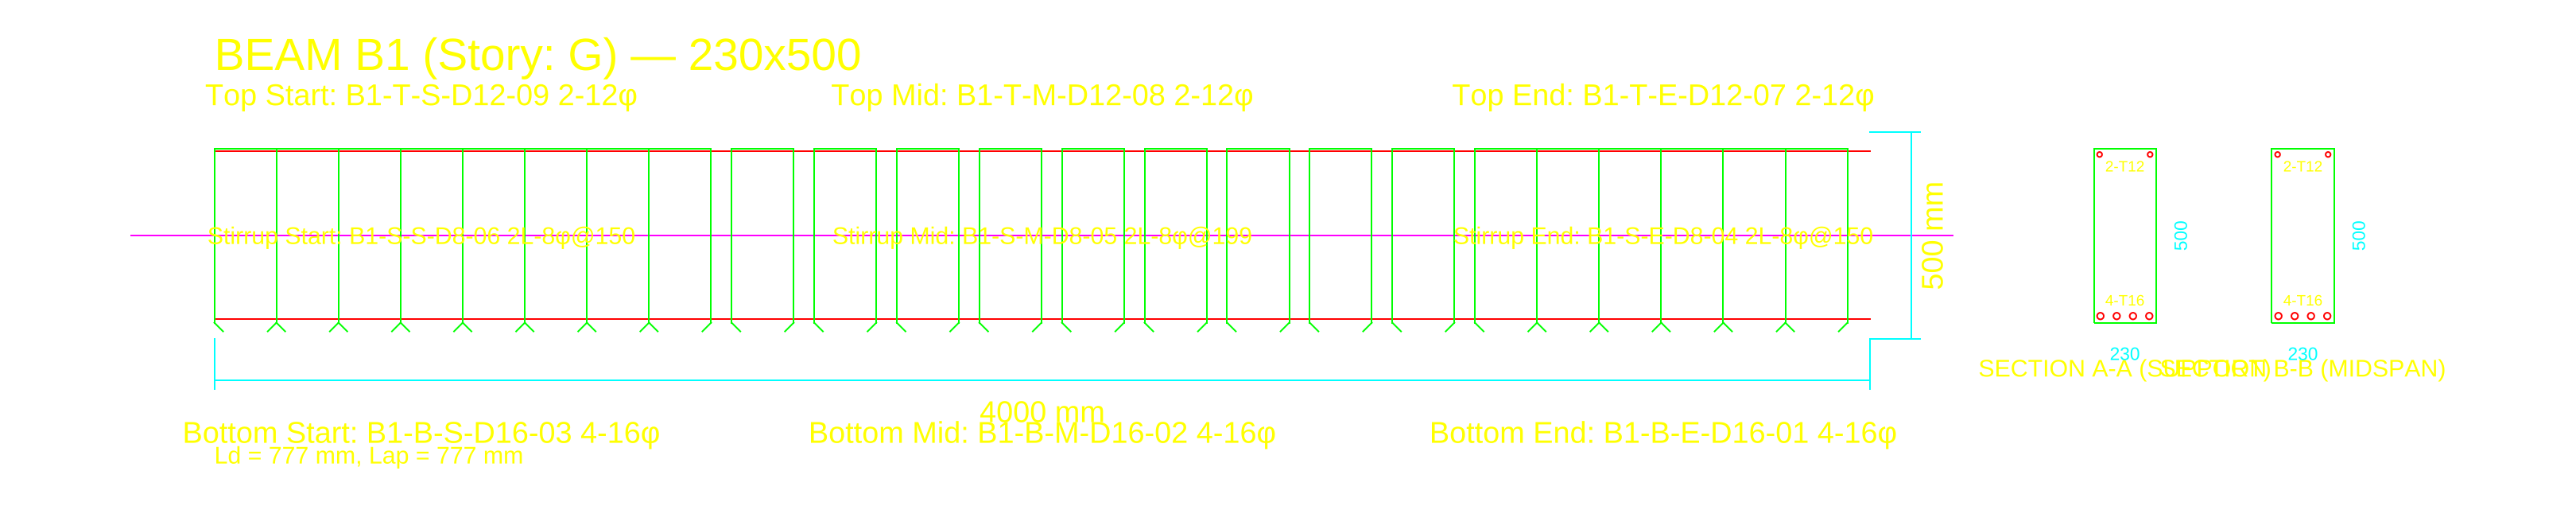

In [12]:
from IPython.display import Image, display
from pathlib import Path

if Path('drawings_small.png').exists():
    display(Image('drawings_small.png'))


## Insights + Smart Designer (v0.15+) - Smart Features

**Available in v0.15.0+** - Install with: `!pip install -U "structural-lib-is456[dxf]>=0.15.0"`

The insights stack includes:
1. **Quick Precheck** - Heuristic validation before full design (~1ms)
2. **Sensitivity Analysis** - Identify critical parameters and robustness
3. **Constructability Scoring** - Ease of construction assessment (0-100 scale)
4. **Smart Designer Dashboard** - Unified cost/suggestions/sensitivity/constructability
5. **Comparison + Cost-Aware Sensitivity** - Trade-offs and cost impact


In [13]:
# Example 1: Quick Precheck (Advisory - catches likely failures before full design)
from structural_lib.insights import quick_precheck

precheck_result = quick_precheck(
    span_mm=6000,
    b_mm=300,
    d_mm=400,  # Might be too shallow for 6m span
    D_mm=450,
    mu_knm=140,
    fck_nmm2=25,
    fy_nmm2=500
)

print(f"Risk Level: {precheck_result.risk_level}")
print(f"Execution Time: {precheck_result.check_time_ms:.2f} ms")
print(f"\nWarnings ({len(precheck_result.warnings)}):")
for w in precheck_result.warnings:
    emoji = '🔴' if w.severity == 'ERROR' else '🟡' if w.severity == 'WARNING' else 'ℹ️'
    print(f"  {emoji} {w.message}")
    print(f"     Suggestion: {w.suggestion}")

Risk Level: LOW
Execution Time: 0.06 ms

Warnings (0):


In [14]:
# Example 2: Sensitivity Analysis (Identify critical parameters)
from structural_lib.insights import sensitivity_analysis
from structural_lib.api import design_beam_is456

# Define baseline parameters
params = {
    "units": "IS456",
    "mu_knm": 120.0,
    "vu_kn": 80.0,
    "b_mm": 300.0,
    "D_mm": 500.0,
    "d_mm": 450.0,
    "fck_nmm2": 25.0,
    "fy_nmm2": 500.0,
}

# Run sensitivity analysis
sensitivities, robustness = sensitivity_analysis(
    design_function=design_beam_is456,
    base_params=params,
    parameters_to_vary=["d_mm", "b_mm", "fck_nmm2", "fy_nmm2"]
)

print("Sensitivity Analysis Results (Ranked by Impact):")
print("=" * 70)
for s in sensitivities:
    direction = "↑ increases" if s.sensitivity > 0 else "↓ decreases"
    impact_pct = abs(s.sensitivity) * 10  # For 10% parameter change
    print(f"{s.parameter:12s}: S={s.sensitivity:+.3f} [{s.impact.upper():8s}]")
    print(f"               → 10% increase {direction} utilization by {impact_pct:.1f}%")

print(f"\nRobustness Score: {robustness.score:.2f} ({robustness.rating.upper()})")
print(f"Vulnerable Parameters: {', '.join(robustness.vulnerable_parameters)}")

Sensitivity Analysis Results (Ranked by Impact):
d_mm        : S=-1.736 [HIGH    ]
               → 10% increase ↓ decreases utilization by 17.4%
fck_nmm2    : S=-0.909 [HIGH    ]
               → 10% increase ↓ decreases utilization by 9.1%
b_mm        : S=-0.909 [HIGH    ]
               → 10% increase ↓ decreases utilization by 9.1%
fy_nmm2     : S=+0.284 [MEDIUM  ]
               → 10% increase ↑ increases utilization by 2.8%

Robustness Score: 1.00 (EXCELLENT)
Vulnerable Parameters: d_mm, fck_nmm2, b_mm, fy_nmm2


In [15]:
# Example 3: Constructability Scoring (Ease of construction)
# Score is 0-100 scale: 85+ excellent, 70-84 good, 55-69 acceptable, <55 poor
from structural_lib.insights import calculate_constructability_score
from structural_lib.api import design_beam_is456, detail_beam_is456

# Design a beam (reusing params from above)
design_result = design_beam_is456(**params)

# detail_beam_is456 expects explicit Ast/Asc values (mm^2) for start/mid/end zones
ast_req_mm2 = float(design_result.flexure.ast_required)
asc_req_mm2 = float(getattr(design_result.flexure, "asc_required", 0.0))

# Create a simple detailing input (using same Ast across zones for demo)
detailing = detail_beam_is456(
    units=params["units"],
    beam_id="B1",
    story="G",
    b_mm=params["b_mm"],
    D_mm=params["D_mm"],
    span_mm=5000,
    cover_mm=40,
    fck_nmm2=params["fck_nmm2"],
    fy_nmm2=params["fy_nmm2"],
    ast_start_mm2=ast_req_mm2,
    ast_mid_mm2=ast_req_mm2,
    ast_end_mm2=ast_req_mm2,
    asc_start_mm2=asc_req_mm2,
    asc_mid_mm2=asc_req_mm2,
    asc_end_mm2=asc_req_mm2,
 )

# Calculate constructability score
constructability = calculate_constructability_score(
    design_result=design_result,
    detailing=detailing
)

print(f"Constructability Score: {constructability.score:.1f}/100 (Rating: {constructability.rating.upper()})")
print(f"\n{constructability.overall_message}")
print("\nFactor Breakdown:")
for factor in constructability.factors:
    sign = "+" if factor.score >= 0 else ""
    print(f"  • {factor.factor}: {sign}{factor.score:.1f} pts")
    print(f"    {factor.message}")
    if factor.recommendation:
        print(f"    💡 {factor.recommendation}")

Constructability Score: 90.0/100 (Rating: EXCELLENT)

Constructability: 90/100 (excellent)

Factor Breakdown:
  • bar_spacing: +0.0 pts
    Clear spacing 47mm is tight
    💡 Consider spacing >= 60mm for easier placement. Impact: Increased labor time.
  • bar_variety: +0.0 pts
    3 bar sizes used (procurement complexity)
    💡 Limit to 2 bar sizes where possible. Impact: Procurement delays, site confusion risk.
  • standard_sizes: +5.0 pts
    All bars are standard sizes
  • depth_increment: +5.0 pts
    Depth 500mm is 50mm multiple (formwork reuse)


In [16]:
# Example 4: CLI with --insights flag (JSON export)
# The --insights flag outputs precheck, sensitivity, and robustness to a separate JSON file

!python -m structural_lib design beams_small.csv -o results_insights.json --insights

# View the insights output
import json
from pathlib import Path

insights_file = Path('results_insights_insights.json')
if insights_file.exists():
    with open(insights_file, encoding='utf-8') as f:
        insights_data = json.load(f)
    print("Insights JSON keys:", list(insights_data.keys()))
    beams = insights_data.get("beams", [])
    if beams:
        beam0 = beams[0]
        print("Beam ID:", beam0.get("beam_id", "N/A"))
        precheck = beam0.get("precheck", {})
        robustness = beam0.get("robustness", {})
        print(f"\nPrecheck risk level: {precheck.get('risk_level', 'N/A')}")
        score = robustness.get("score", None)
        if score is None:
            print("Robustness score: N/A")
        else:
            print(f"Robustness score: {float(score):.2f}")
    else:
        print("No beams found in insights JSON")
else:
    print("Insights file not generated - run design command first")

Loading beam data from beams_small.csv...
Loaded 1 beam(s)
  Processing G/B1...
Computing advisory insights...
  Insights for G/B1...
Design results written to results_insights.json
Insights written to results_insights_insights.json
Design complete: 1 beam(s) processed
Insights JSON keys: ['schema_version', 'insights_version', 'beams']
Beam ID: B1

Precheck risk level: LOW
Robustness score: 1.00


## Smart Designer Dashboard (v0.15+)

Run the full design + unified insights in one call.


In [17]:
from structural_lib.api import smart_analyze_design

dashboard = smart_analyze_design(
    units="IS456",
    span_mm=5000,
    mu_knm=120,
    vu_kn=80,
    b_mm=300,
    D_mm=500,
    d_mm=450,
    fck_nmm2=25,
    fy_nmm2=500,
    output_format="dict",
)

summary = dashboard["summary"]
print(f"Overall Score: {summary['overall_score'] * 100:.1f}/100")
print(f"Safety Score: {summary['safety_score'] * 100:.1f}/100")
print(f"Cost Efficiency: {summary['cost_efficiency'] * 100:.1f}/100")

top_suggestions = dashboard.get("suggestions", {}).get("top_3", [])
if top_suggestions:
    print("Top Suggestion:", top_suggestions[0].get("title", "N/A"))

print("\nText Summary:")
print(smart_analyze_design(
    units="IS456",
    span_mm=5000,
    mu_knm=120,
    vu_kn=80,
    b_mm=300,
    D_mm=500,
    d_mm=450,
    fck_nmm2=25,
    fy_nmm2=500,
    output_format="text",
))


Overall Score: 85.4/100
Safety Score: 59.1/100
Cost Efficiency: 90.8/100
Top Suggestion: Explore cost-optimized designs

Text Summary:
SMART DESIGN DASHBOARD

📊 Overall Score: 85.4%
   • Safety:          59.1%
   • Cost Efficiency: 90.8%
   • Constructability: 100.0%
   • Robustness:     100.0%

✅ Status: WARNING

⚠️  Key Issues:
   • Low safety margin - review design

💡 Quick Wins:
   • 1 high-impact improvements available

----------------------------------------------------------------------
💰 COST ANALYSIS
----------------------------------------------------------------------
Current Cost:  ₹13,675
Optimal Cost:  ₹8,591
Savings:       9.2%

----------------------------------------------------------------------
🔍 DESIGN SUGGESTIONS
----------------------------------------------------------------------
Total: 1 | High: 1 | Medium: 0 | Low: 0

Top 3 Recommendations:
1. [high] cost
   

----------------------------------------------------------------------
📈 SENSITIVITY ANALYSIS
------

## Comparison + Cost-Aware Sensitivity (v0.15+)

Compare alternatives and understand which parameters drive cost the most.


In [18]:
from structural_lib.api import design_beam_is456
from structural_lib.insights import compare_designs, DesignAlternative
from structural_lib.costing import (
    CostProfile,
    calculate_concrete_volume,
    calculate_formwork_area,
    calculate_steel_weight,
)

cost_profile = CostProfile()
span_mm = 5000

def estimate_cost(result, b_mm, D_mm, fck_nmm2, span_mm, cost_profile):
    conc_vol = calculate_concrete_volume(b_mm, D_mm, span_mm)
    conc_cost = conc_vol * cost_profile.concrete_costs.get(int(fck_nmm2), 6700)
    steel_kg = calculate_steel_weight(result.flexure.ast_required, span_mm)
    steel_cost = steel_kg * cost_profile.steel_cost_per_kg
    form_area = calculate_formwork_area(b_mm, D_mm, span_mm)
    form_cost = form_area * cost_profile.formwork_cost_per_m2
    return conc_cost + steel_cost + form_cost

alt_a_params = {
    "units": "IS456",
    "case_id": "ALT-A",
    "mu_knm": 120.0,
    "vu_kn": 80.0,
    "b_mm": 300.0,
    "D_mm": 500.0,
    "d_mm": 450.0,
    "fck_nmm2": 25.0,
    "fy_nmm2": 500.0,
}

alt_b_params = {
    "units": "IS456",
    "case_id": "ALT-B",
    "mu_knm": 120.0,
    "vu_kn": 80.0,
    "b_mm": 250.0,
    "D_mm": 550.0,
    "d_mm": 500.0,
    "fck_nmm2": 30.0,
    "fy_nmm2": 500.0,
}

alt_a_result = design_beam_is456(**alt_a_params)
alt_b_result = design_beam_is456(**alt_b_params)

alt_a_cost = estimate_cost(
    alt_a_result,
    alt_a_params["b_mm"],
    alt_a_params["D_mm"],
    alt_a_params["fck_nmm2"],
    span_mm,
    cost_profile,
)
alt_b_cost = estimate_cost(
    alt_b_result,
    alt_b_params["b_mm"],
    alt_b_params["D_mm"],
    alt_b_params["fck_nmm2"],
    span_mm,
    cost_profile,
)

alt_a = DesignAlternative("Option A: 300x500", alt_a_params, alt_a_result, cost=alt_a_cost)
alt_b = DesignAlternative("Option B: 250x550", alt_b_params, alt_b_result, cost=alt_b_cost)

comparison = compare_designs([alt_a, alt_b])
best = comparison.alternatives[comparison.best_alternative_idx]
print("Best option:", best.name)
print("Trade-offs:", comparison.trade_offs)


Best option: Option B: 250x550
Trade-offs: []


In [19]:
from structural_lib.insights import cost_aware_sensitivity, CostProfile

base_params = {
    "units": "IS456",
    "mu_knm": 120.0,
    "vu_kn": 80.0,
    "b_mm": 300.0,
    "D_mm": 500.0,
    "d_mm": 450.0,
    "fck_nmm2": 25.0,
    "fy_nmm2": 500.0,
}

cost_profile = CostProfile()
results, base_cost = cost_aware_sensitivity(
    design_beam_is456,
    base_params,
    cost_profile,
    parameters_to_vary=["d_mm", "b_mm", "fck_nmm2"],
)

print(f"Base cost (approx): {base_cost:,.0f} {cost_profile.currency}")
for r in results[:3]:
    print(f"{r.parameter}: {r.impact.upper()} | {r.recommendation}")


Base cost (approx): 13,675 INR
d_mm: HIGH | HIGH: Adjust this parameter (low cost impact)
fck_nmm2: HIGH | HIGH: Adjust this parameter (low cost impact)
b_mm: HIGH | HIGH: Trade-off parameter (safety vs cost)


### Insights Summary

The insights stack helps you:
- **Precheck**: Catch geometry/loading issues before expensive full design (~1ms)
- **Sensitivity**: Understand which parameters most affect your design margin
- **Constructability**: Score ease of construction (0-100) with actionable recommendations
- **Smart Designer**: Unified dashboard with cost/suggestions/sensitivity/constructability
- **Comparison**: Compare alternatives and surface trade-offs with cost-aware sensitivity

All insights are advisory - the main design always runs. See [Insights API Reference](../reference/insights-api.md) for complete documentation.
